🚀 TP TRM-VISION – Fashion-MNIST Kaggle (TRM small + classifier)
Path to dataset files: C:\Users\User\.cache\kagglehub\datasets\zalando-research\fashionmnist\versions\4
✅ Fashion-MNIST Kaggle: x_train=(60000, 16, 16), y_train=(60000,)

🔧 Entraînement TRM small (Fashion-MNIST, 10 époques)...
Epoch 1/20
32/32 [==============================] - 60s 2s/step - loss: 0.7878 - val_loss: 0.7868
Epoch 2/20
32/32 [==============================] - 43s 1s/step - loss: 0.6875 - val_loss: 0.5747
Epoch 3/20
32/32 [==============================] - 43s 1s/step - loss: 0.4845 - val_loss: 0.3209
Epoch 4/20
32/32 [==============================] - 43s 1s/step - loss: 0.2402 - val_loss: 0.2121
Epoch 5/20
32/32 [==============================] - 43s 1s/step - loss: 0.2008 - val_loss: 0.1918
Epoch 6/20
32/32 [==============================] - 51s 2s/step - loss: 0.1836 - val_loss: 0.1820
Epoch 7/20
32/32 [==============================] - 54s 2s/step - loss: 0.1877 - val_loss: 0.2366
Epoch 8/20
32/32 [=====

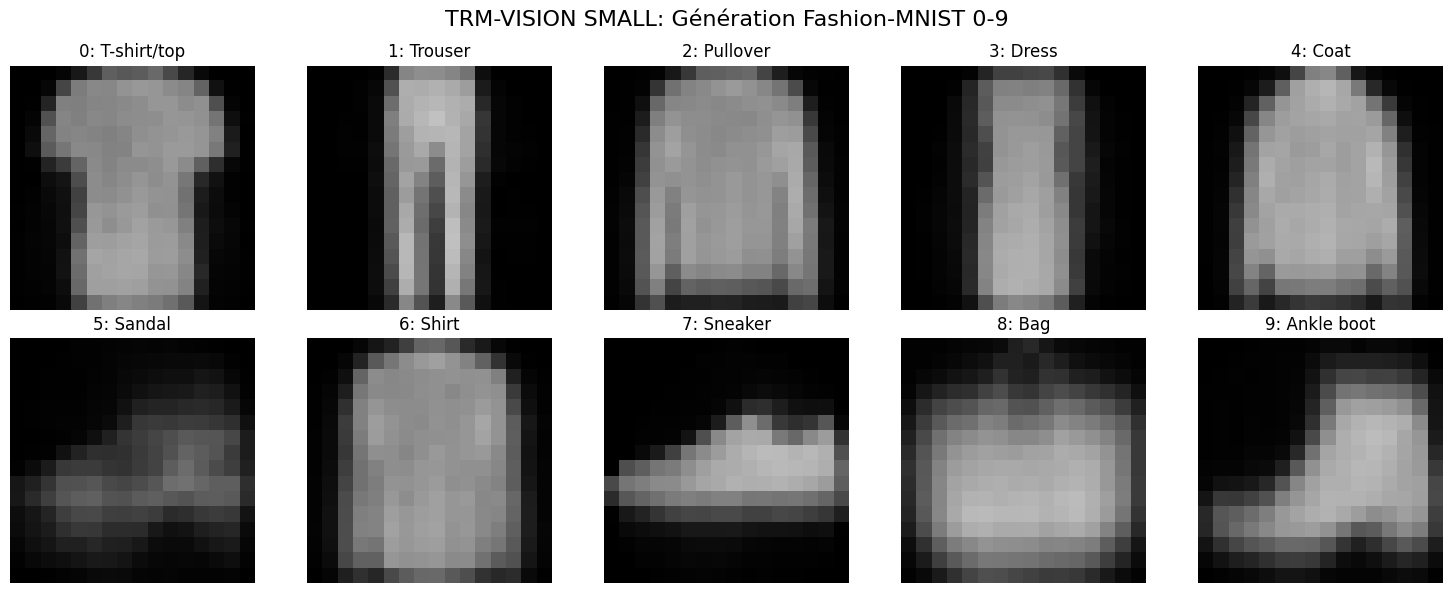

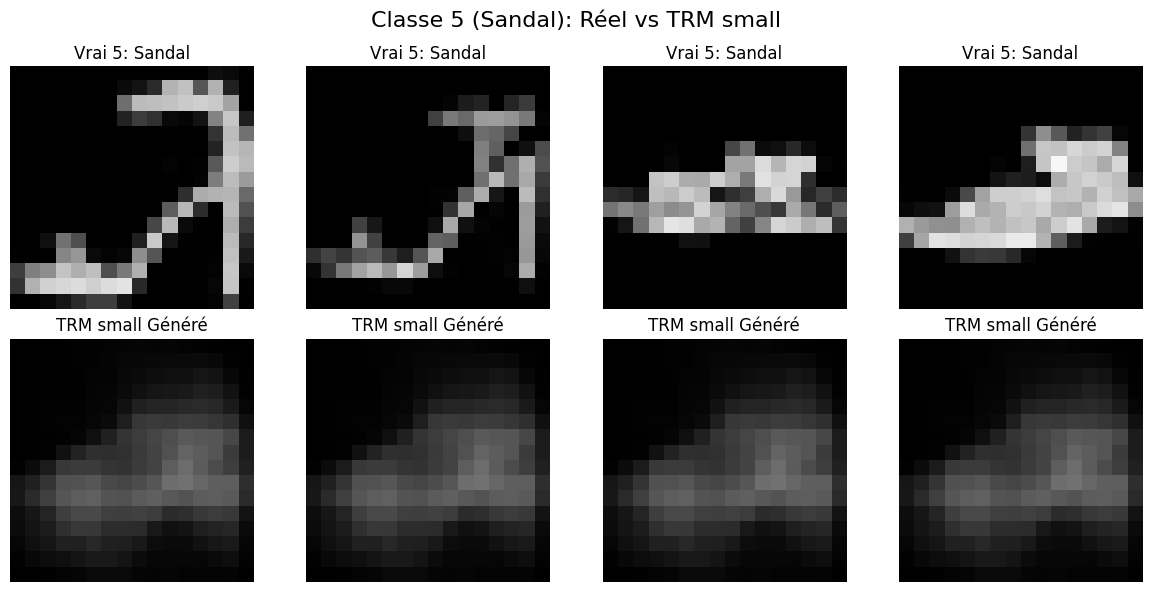

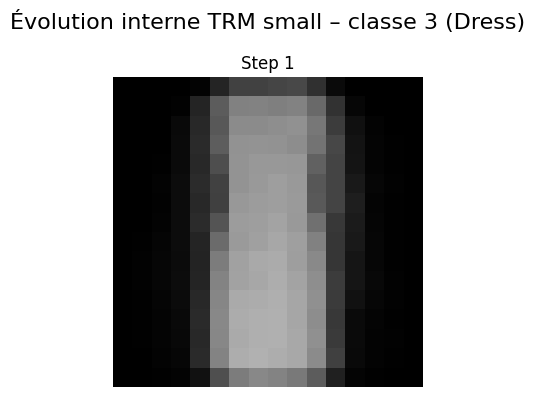


🎉 Résumé TP TRM-VISION – Fashion-MNIST Kaggle (TRM small)
   → TRM small: d=32, n_rec=2, loss fin:  0.1760
   → CNN val accuracy: 80.30%
   → Reconnaissance CNN sur images Fashion-MNIST TRM small: 91.20%
   → Figures: grille 0-9 (vêtements), vrai vs généré, trajectoire interne


In [37]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import kagglehub

print("🚀 TP TRM-VISION – Fashion-MNIST Kaggle (TRM small + classifier)")

# =============================================================================
# 0. Download Kaggle Fashion-MNIST
# =============================================================================
path = kagglehub.dataset_download("zalando-research/fashionmnist")
print("Path to dataset files:", path)

train_csv = os.path.join(path, "fashion-mnist_train.csv")
test_csv  = os.path.join(path, "fashion-mnist_test.csv")

# =============================================================================
# 1. TinyBlock
# =============================================================================
class TinyBlock(layers.Layer):
    def __init__(self, d):
        super().__init__()
        self.ln = layers.LayerNormalization()
        self.fc1 = layers.Dense(4 * d, activation="gelu")
        self.fc2 = layers.Dense(d)

    def call(self, u):
        h = self.ln(u)
        h = self.fc1(h)
        h = self.fc2(h)
        return u + h

# =============================================================================
# 2. TRM-VISION small
# =============================================================================
class TRM_VISION(keras.Model):
    def __init__(self, img_size=16, d=32, n_rec=2, name_suffix="small"):
        super().__init__(name=f"TRM_VISION_{name_suffix}")
        self.img_size = img_size
        self.d = d
        self.n_rec = n_rec
        
        self.cond_emb = layers.Embedding(10, d)
        self.y0 = self.add_weight(
            shape=(1, img_size*img_size, d),
            initializer="zeros",
            trainable=True,
            name=f"y0_{name_suffix}"
        )
        self.z0 = self.add_weight(
            shape=(1, img_size*img_size, d),
            initializer="zeros",
            trainable=True,
            name=f"z0_{name_suffix}"
        )
        self.block1 = TinyBlock(d)
        self.block2 = TinyBlock(d)
        self.to_pixels = layers.Dense(1)

    def call(self, class_tokens, target_img=None, return_intermediate=False):
        B = tf.shape(class_tokens)[0]
        L = self.img_size * self.img_size
        
        c = self.cond_emb(class_tokens)              
        c = tf.tile(tf.expand_dims(c, 1), [1, L, 1]) 
        
        y = tf.tile(self.y0, [B, 1, 1])
        z = tf.tile(self.z0, [B, 1, 1])
        
        inter_imgs = []

        for _ in range(self.n_rec):
            z = self.block2(self.block1(c + y + z))
            y = self.block2(self.block1(y + z))

        pixels = self.to_pixels(y)
        img = tf.tanh(tf.reshape(pixels, [B, self.img_size, self.img_size, 1]))
        if return_intermediate:
            inter_imgs.append(img)

        loss = None
        if target_img is not None:
            loss = tf.reduce_mean(tf.keras.losses.mse(target_img, img))

        if return_intermediate:
            return img, loss, inter_imgs
        if loss is None:
            return img
        return img, loss

# =============================================================================
# 3. Dataset Kaggle Fashion-MNIST → 16x16
# =============================================================================
def load_fashion_mnist_csv(csv_path):
    df = pd.read_csv(csv_path)
    labels = df['label'].values.astype(np.int64)
    pixels = df.drop(columns=['label']).values.astype(np.float32)
    images = pixels.reshape(-1, 28, 28)
    return images, labels

x_train_full, y_train = load_fashion_mnist_csv(train_csv)
x_test_full,  y_test  = load_fashion_mnist_csv(test_csv)

x_train_full = x_train_full / 127.5 - 1.0
x_test_full  = x_test_full  / 127.5 - 1.0

x_train = np.squeeze(tf.image.resize(tf.expand_dims(x_train_full, -1), [16, 16]).numpy())
x_test  = np.squeeze(tf.image.resize(tf.expand_dims(x_test_full,  -1), [16, 16]).numpy())

print(f"✅ Fashion-MNIST Kaggle: x_train={x_train.shape}, y_train={y_train.shape}")

# Sous-échantillonnage raisonnable
train_idx = 8000
val_idx   = 2000

x_train_small = x_train[:train_idx]
y_train_small = y_train[:train_idx]
x_val_small   = x_test[:val_idx]
y_val_small   = y_test[:val_idx]

# =============================================================================
# 4. TRM small 
# =============================================================================
trm_small = TRM_VISION(img_size=16, d=32, n_rec=2, name_suffix="small")
trm_small.compile(optimizer='adam', loss='mse')

print("\n🔧 Entraînement TRM small (Fashion-MNIST, 20 époques)...")
hist_small = trm_small.fit(
    y_train_small, x_train_small,
    epochs=20, batch_size=256, verbose=1,
    validation_data=(y_val_small, x_val_small)
)

# =============================================================================
# 5. CNN classifier Fashion-MNIST 16x16
# =============================================================================
print("\n🔧 Entraînement CNN classifier Fashion-MNIST (16x16)...")

cnn = keras.Sequential([
    layers.Input(shape=(16, 16, 1)),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPool2D(2),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")
])

cnn.compile(optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])

cnn.fit(
    x_train_small[..., np.newaxis], y_train_small,
    epochs=20, batch_size=256, verbose=1,
    validation_data=(x_val_small[..., np.newaxis], y_val_small)
)

# =============================================================================
# 6. Évaluation: taux de reconnaissance des images générées
# =============================================================================
def eval_trm_with_cnn(trm_model, name, n_samples=500):
    labels = np.random.randint(0, 10, size=(n_samples,))
    gen_imgs = trm_model(tf.constant(labels)).numpy()
    preds = cnn.predict(gen_imgs, verbose=0)
    pred_labels = preds.argmax(axis=1)
    acc = (pred_labels == labels).mean()
    print(f"📊 Taux de reconnaissance CNN sur images Fashion-MNIST générées ({name}): {acc*100:.2f}%")
    return acc, gen_imgs, labels

acc_small, gen_small_imgs, gen_small_labels = eval_trm_with_cnn(trm_small, "TRM small")

# =============================================================================
# 7. Grille de génération 0-9 
# =============================================================================
class_names = [
    "T-shirt/top","Trouser","Pullover","Dress","Coat",
    "Sandal","Shirt","Sneaker","Bag","Ankle boot"
]

def plot_grid(trm_model, title):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(10):
        gen_imgs = trm_model(tf.constant([i]))
        axes[i//5, i%5].imshow(gen_imgs[0, :, :, 0], cmap='gray', vmin=-1, vmax=1)
        axes[i//5, i%5].set_title(f"{i}: {class_names[i]}")
        axes[i//5, i%5].axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

plot_grid(trm_small, "TRM-VISION SMALL: Génération Fashion-MNIST 0-9")

# =============================================================================
# 8. Target vs généré pour une classe 
# =============================================================================
def plot_target_vs_gen(model, x_test_arr, y_test_arr, digit=5, title_prefix="TRM"):
    idx = np.where(y_test_arr == digit)[0][:4]
    target = x_test_arr[idx]
    gen = model(tf.constant([digit]*4)).numpy()
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i in range(4):
        axes[0,i].imshow(target[i], cmap='gray', vmin=-1, vmax=1)
        axes[0,i].set_title(f"Vrai {digit}: {class_names[digit]}")
        axes[0,i].axis('off')
        axes[1,i].imshow(gen[i, :, :, 0], cmap='gray', vmin=-1, vmax=1)
        axes[1,i].set_title(f"{title_prefix} Généré")
        axes[1,i].axis('off')
    plt.suptitle(f"Classe {digit} ({class_names[digit]}): Réel vs {title_prefix}", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_target_vs_gen(trm_small, x_test, y_test, digit=5, title_prefix="TRM small")

# =============================================================================
# 9. Visualisation trajectoire interne (TRM small, une classe)
# =============================================================================
digit_demo = 3  
_, _, inter_imgs = trm_small(tf.constant([digit_demo]), return_intermediate=True)

fig, axes = plt.subplots(1, len(inter_imgs), figsize=(4*len(inter_imgs), 4))
if len(inter_imgs) == 1:
    axes = [axes]

for i, img_t in enumerate(inter_imgs):
    axes[i].imshow(img_t[0, :, :, 0].numpy(), cmap='gray', vmin=-1, vmax=1)
    axes[i].set_title(f"Step {i+1}")
    axes[i].axis('off')
plt.suptitle(f"Évolution interne TRM small – classe {digit_demo} ({class_names[digit_demo]})", fontsize=16)
plt.tight_layout()
plt.show()

# =============================================================================
# 10. Récapitulatif console
# =============================================================================
val_acc_cnn = cnn.evaluate(x_val_small[...,np.newaxis], y_val_small, verbose=0)[1]*100
print("\n" + "="*70)
print("🎉 Résumé TP TRM-VISION – Fashion-MNIST Kaggle (TRM small)")
print(f"   → TRM small: d=32, n_rec=2, loss fin:  {hist_small.history['loss'][-1]:.4f}")
print(f"   → CNN val accuracy: {val_acc_cnn:.2f}%")
print(f"   → Reconnaissance CNN sur images Fashion-MNIST TRM small: {acc_small*100:.2f}%")
print("   → Figures: grille 0-9 (vêtements), vrai vs généré, trajectoire interne")
print("="*70)


In [38]:
# =============================================================================
# 11. Démo utilisateur : prédire la classe d'une image de vêtement
# =============================================================================
from PIL import Image

def preprocess_user_image(img_path):
    """
    Charge une image utilisateur, la convertit en 16x16 niveaux de gris
    et la normalise dans [-1, 1] comme Fashion-MNIST.
    """
    img = Image.open(img_path).convert("L")  # Niveaux de gris
    img = img.resize((16, 16))              # Même taille que le modèle
    img_np = np.array(img).astype(np.float32)
    img_np = img_np / 127.5 - 1.0           # Normalisation [-1,1]
    return img_np

def predict_user_image(img_path):
    img_np = preprocess_user_image(img_path)
    x = img_np[np.newaxis, ..., np.newaxis]  # [1,16,16,1]
    preds = cnn.predict(x, verbose=0)
    pred_class = int(np.argmax(preds[0]))
    prob = float(np.max(preds[0]))
    
    plt.figure(figsize=(3,3))
    plt.imshow(img_np, cmap="gray", vmin=-1, vmax=1)
    plt.title(f"Prédiction: {pred_class} – {class_names[pred_class]} ({prob*100:.1f} %)")
    plt.axis("off")
    plt.show()
    
    return pred_class, prob

# Exemple d'utilisation :
# 1) mets une image dans ton dossier, par ex. "mon_tshirt.png" ou "shoe.jpg"
# 2) appelle:
# pred_class, prob = predict_user_image("mon_image_vetement.png")


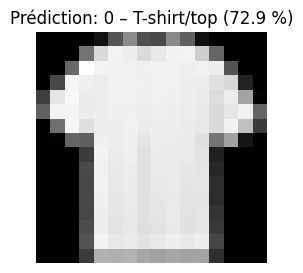

In [39]:
pred_class, prob = predict_user_image("1.png")  # Remplace par le nom de ton fichier image

In [40]:
# =============================================================================
# 12. Démo complète : image utilisateur → classe CNN → image TRM générée
# =============================================================================

def user_demo_with_trm(img_path):
    """
    1) Charge une image utilisateur.
    2) La passe dans le CNN pour prédire la classe de vêtement.
    3) Génère une image 'prototype' avec TRM pour la classe prédite.
    4) Affiche les deux côte à côte.
    """
    # Prétraitement identique à predict_user_image
    img = Image.open(img_path).convert("L")
    img = img.resize((16, 16))
    img_np = np.array(img).astype(np.float32)
    img_np_norm = img_np / 127.5 - 1.0

    x = img_np_norm[np.newaxis, ..., np.newaxis]  # [1,16,16,1]
    preds = cnn.predict(x, verbose=0)
    pred_class = int(np.argmax(preds[0]))
    prob = float(np.max(preds[0]))

    # Génération TRM à partir de la classe prédite
    gen_img = trm_small(tf.constant([pred_class])).numpy()[0, :, :, 0]

    # Affichage côte à côte
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    
    axes[0].imshow(img_np_norm, cmap="gray", vmin=-1, vmax=1)
    axes[0].set_title(f"Image utilisateur\nPrédiction: {pred_class} – {class_names[pred_class]}\n({prob*100:.1f} %)")
    axes[0].axis("off")
    
    axes[1].imshow(gen_img, cmap="gray", vmin=-1, vmax=1)
    axes[1].set_title(f"Prototype TRM\nClasse {pred_class} – {class_names[pred_class]}")
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()
    
    return pred_class, prob

# Exemple d'utilisation :
# user_demo_with_trm("mon_image_vetement.png")


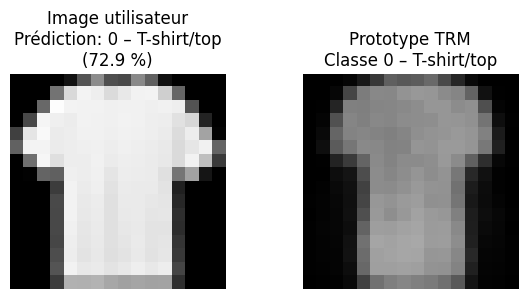

(0, 0.7287481427192688)

In [41]:
user_demo_with_trm("1.png")  # Remplace par le nom de ton fichier image